# PyTorch VAE

## References
* [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)
* [Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf)



## Load Data

In [1]:
import matplotlib
%matplotlib inline

from torchvision import transforms, datasets, utils
import torch
import matplotlib.pyplot as plt
import numpy as np
from random import choice

In [2]:
tfms = transforms.ToTensor()

In [3]:
trainset = datasets.MNIST(root='~/Code/dl/datasets', train=True, download=True, transform=tfms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
print(f'Number of training samples: {len(trainset)}')

testset = datasets.MNIST(root='~/Code/dl/datasets', train=False, download=True, transform=tfms)
testloader = torch.utils.data.DataLoader(testset, batch_size=4096, shuffle=True, num_workers=4)
print(f'Number of testing samples: {len(testset)}')

Number of training samples: 60000
Number of testing samples: 10000


In [4]:
dimensions = (1, 28, 28)

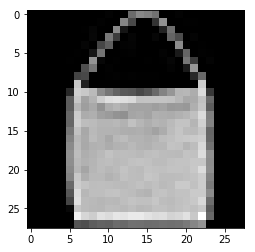

In [5]:
plt.imshow(np.squeeze(choice(trainset)[0]), cmap='gray')

## Define Model and Loss

In [6]:
from torch import nn
from torch.nn import functional as F

In [7]:
# maps image to µ and σ of approximate gaussian posterior
class VAE(nn.Module):
    def __init__(self, inp_len, latent_size):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(inp_len, 1000),
            nn.ReLU(),
            nn.Linear(1000, 200),
            nn.ReLU()
        )
        self.mu = nn.Linear(200, latent_size)
        self.sigma = nn.Linear(200, latent_size)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, inp_len),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        return self.mu(encoded), self.sigma(encoded)
    
    def decode(self, z):
        return self.decoder(z).view(-1, *dimensions)
    
    def random_z(self, mu, sigma):
        return torch.randn_like(mu) * sigma + mu
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        z = self.random_z(mu, sigma)
        return self.decode(z), mu, sigma

In [8]:
def kl_loss(mu, sigma):
    sigma_squared = sigma.pow(2)
    return -0.5 * torch.sum(1 + torch.log(sigma_squared) - mu.pow(2) - sigma_squared)

In [9]:
def recon_loss(pred, inp):
    return F.binary_cross_entropy(pred, inp, size_average=False)

## Training

In [10]:
device = torch.device('cuda')

vae = VAE(int(np.product(dimensions)), 20).to(device)

In [11]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [12]:
vae.train()
epochs = 10
for epoch in range(epochs):
    print(f'\nEPOCH {epoch + 1}/{epochs}')
    
    total_loss = 0
        
    for i, (data, _) in enumerate(trainloader):
        data = data.to(device)
        
        optimizer.zero_grad()
        recon, mu, sigma = vae(data)
        loss = recon_loss(recon, data) + kl_loss(mu, sigma)
        total_loss += loss

        loss.backward() 
        optimizer.step()
    
    print(f'Average loss: {total_loss / len(trainloader.dataset)}')


EPOCH 1/10
Average loss: 276.3846130371094

EPOCH 2/10
Average loss: 273.82952880859375

EPOCH 3/10
Average loss: 256.52569580078125

EPOCH 4/10
Average loss: 249.23297119140625

EPOCH 5/10
Average loss: 245.6685791015625

EPOCH 6/10
Average loss: 243.79998779296875

EPOCH 7/10
Average loss: 248.87513732910156

EPOCH 8/10
Average loss: 261.0177917480469

EPOCH 9/10
Average loss: 261.6137390136719

EPOCH 10/10
Average loss: 270.27520751953125


## Testing

In [13]:
def test_cycle(img):
    generated, _, _ = vae.forward(img.unsqueeze(0).to(device))
    generated = generated.detach().cpu().squeeze(0)

    print('Original on left, generated on right')
    grid = utils.make_grid([img, generated])
    plt.imshow(np.transpose(grid, (1, 2, 0)))

Original on left, generated on right


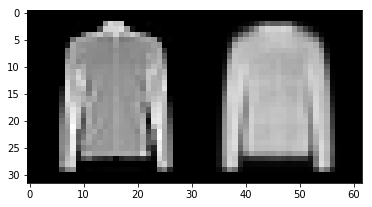

In [14]:
test_cycle(choice(testset)[0])

In [15]:
def test_random():
    generated = vae.decode(torch.randn((1, 20)).to(device))
    generated = generated.detach().cpu().squeeze().numpy()
    
    plt.imshow(generated, cmap='gray')

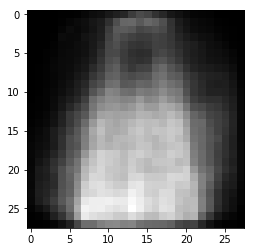

In [16]:
test_random()

In [17]:
def test_interpolate(start, end, n_steps=8):
    mu, sigma = vae.encode(start.cuda())
    start_z = vae.random_z(mu, sigma).detach().squeeze()
    
    mu, sigma = vae.encode(end.cuda())
    end_z = vae.random_z(mu, sigma).detach().squeeze()

    step = (end_z - start_z) / n_steps
    
    interpolations = []
    last = start_z
    for i in range(n_steps):
        interpolations.append(last + step * i)
    
    images = []
    for interpolation in interpolations:
        images.append(vae.decode(interpolation).detach().cpu().squeeze(0))
    grid = utils.make_grid(images)
    plt.imshow(np.transpose(grid, (1, 2, 0)))

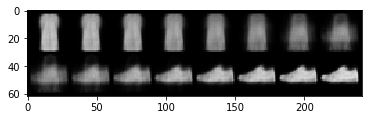

In [18]:
test_interpolate(choice(testset)[0], choice(testset)[0], 16)